# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=2)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.51:8787/status,
Dashboard: http://10.148.1.51:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.51:59857,Workers: 0
Dashboard: http://10.148.1.51:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



In [5]:
dt = 1/24 # time step in days

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)
#print('omega (M2+S2)/2:%s'%(omega_M2+omega_S2)/2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [6]:
h = generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)

In [7]:
h_hat, w = filter_response(h, dt)

No handles with labels found to put in legend.


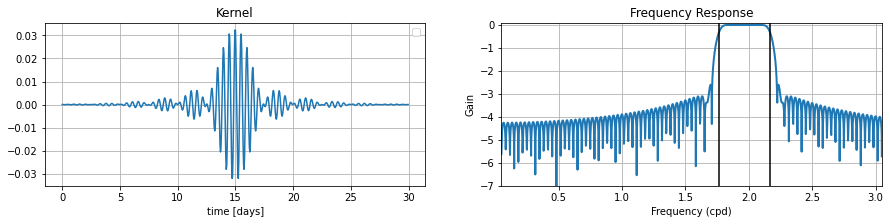

In [8]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband, color='k')
ax.axvline(omega+dband, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

---

## Hilbert transform

### apply band-passed filter and hilbert transform

### Testing parameters

In [6]:
# generate synthetic data
#T,T_low = [14,29,80],10

def rename_attrs(da, **kwargs):
    """ rename attributes
    """
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da

def tseries(kind, params={}, **kwargs):
    _kwargs = dict(time=(t_size, 1/24), 
                   seed=0,
                  )
    _kwargs.update(**kwargs)
    #               T=10.,
    if kind=="high_M2":
        p = dict(U=[1.], T=T, sigma=omega_M2*rad) #[0.01, 0.05,.1, 1.]
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
#        da = (#rename_attrs(da, T_high="T")
#              da.rename(U='U_high')
#            )
    elif kind=="high_S2":
        p = dict(U=[1.], T=T, sigma=omega_S2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
#        da = (#rename_attrs(da, T_high="T")
#              da.rename(U='U_high')
#             )
    elif kind=="high_N2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_N2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    elif kind=="high_K2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_K2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    else:
        p = dict(T=T_low)
        p.update(**params)
        da = (u_low
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = rename_attrs(da, U_low="U") #T_low="T"
    return da

In [7]:
def autocorrelations(ds, V,combine=False,maxlag=None,lags=None,**kwargs):
#    V = ["high", "low"]
#    if combine:
#        ds["sum"] = ds["high"]  + ds["low"]
#        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
#        V = V + ["sum"]
    R = []
    for v in V:
        if v=='low':
            R.append((sigp
                  .correlate(ds[v].real, ds[v].real,maxlag=maxlag,lags=lags,**kwargs)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
        else:
            R.append((sigp
                      .correlate(ds[v+"_demodulated"].real, ds[v+"_demodulated"].real,maxlag=maxlag,lags=lags,**kwargs)
                      .rename(v)
                      .to_dataset()
                      .rename({'lags': 'tau'})
                     )
                    )
    return xr.merge(R)

In [8]:
t_size=80
T,T_low = [5,10,15,30,80],[5,30,100]
U_high = [0.01,0.05,0.1,1.]
Tw = [15,30,60]
dband = [0.05,0.1,0.2,0.3]

### Coherent signal : 

In [13]:
u = hf.high_frequency_signal(stationary=True)

In [14]:
rad = 2*np.pi
p = dict(U=0., Us=1., T=5., sigma=omega_M2*rad)

u_M2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(1000,1/24),
                         draws=30,name='M2'
                        ).persist()


p = dict(U=0., Us=1., T=5., sigma=omega_S2*rad)

u_S2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(1000,1/24),
                         draws=30,name='S2'
                        ).persist()

u_low = hf.low_frequency_signal()
low = tseries("low",draws=30,name='low').persist()

In [15]:
u_high = u_S2+u_M2
u_total = u_S2+u_M2+low

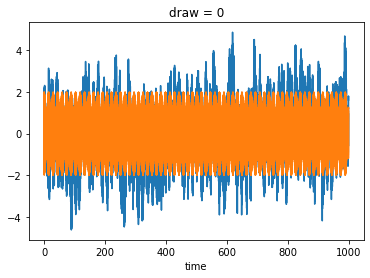

In [16]:
u_total.sel(draw=0,T=5).plot()
u_high.sel(draw=0).plot()

In [17]:
u_high

<xarray.DataArray (time: 24000, draw: 30)>
dask.array<add, shape=(24000, 30), dtype=float64, chunksize=(24000, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

In [18]:
ds = xr.merge([u_M2,u_S2,u_high.rename('high'),u_total.rename('total')])
ds

<xarray.Dataset>
Dimensions:  (T: 3, draw: 30, time: 24000)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * T        (T) int64 5 30 100
Data variables:
    M2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    S2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    high     (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    total    (time, draw, T) float64 dask.array<chunksize=(24000, 30, 3), meta=np.ndarray>

In [19]:
kind = ['M2','S2','high','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]



In [22]:
R = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag=None,lags = lags,**{'mode':'same'})

In [23]:
ds_R = xr.merge([R[k] for k in kind])

In [24]:
ds_R_mean = ds_R.mean('draw').compute()

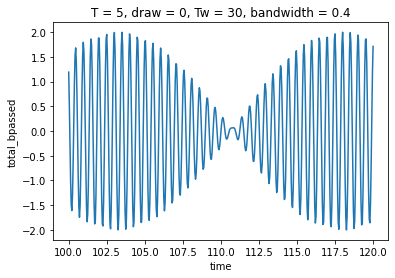

In [25]:
_ds['total'].total_bpassed.real.sel(draw=0,Tw=30,T=5,bandwidth=0.4).sel(time=slice(100,120)).plot()

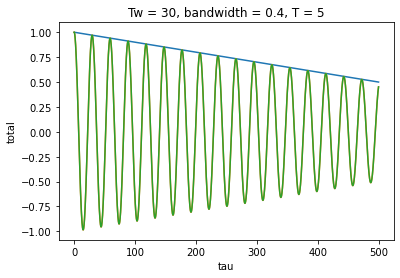

In [26]:
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.high/ds_R_mean.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.total/ds_R_mean.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

Notes : 
Pas de contamination par la basse fréquence.

In [27]:
R_valid = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R_valid[k] = autocorrelations(_ds[k],[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})

In [28]:
ds_R_valid = xr.merge([R_valid[k] for k in kind])

In [29]:
ds_R_mean_valid = ds_R_valid.mean('draw').compute()

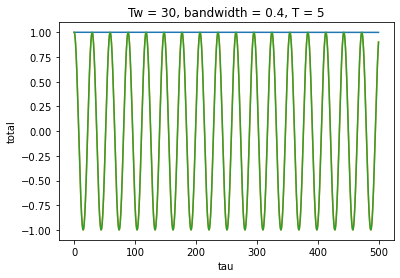

In [30]:
(ds_R_mean_valid.M2/ds_R_mean_valid.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.high/ds_R_mean_valid.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.total/ds_R_mean_valid.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

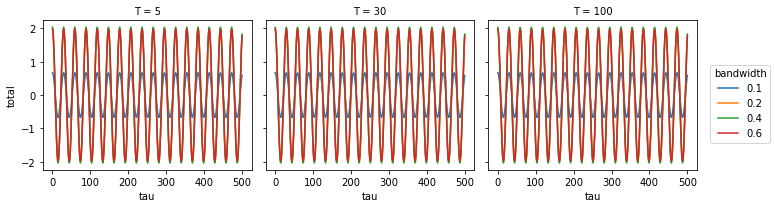

In [35]:
ds_R_mean_valid.total.sel(Tw=30).plot(col='T',hue='bandwidth')

In [31]:
ds_R_mean.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_same.nc')
ds_R_mean_valid.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_valid.nc')

###  Incoherent signal : 1 draw

In [12]:
# actually generate time series

u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
da_high_M2 = tseries("high_M2",draws=1,name='high_M2').persist()
#da_high_M2 = da_high_M2.rename('high_M2')
da_high_S2 = tseries("high_S2",draws=1,name='high_S2').persist()
#da_high_S2 = da_high_S2.rename('high_S2')
#da_high_N2 = tseries("high_N2",draws=1).persist()
#da_high_N2 = da_high_N2.rename('high_N2')
#da_high_K2 = tseries("high_K2",draws=1).persist()
#da_high_K2 = da_high_K2.rename('high_K2')


da_low = tseries("low",draws=1).persist()

In [13]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma']}

#da_high_N2.attrs = {'sigma_N2':da_high_N2.attrs['sigma']}
#da_high_K2.attrs = {'sigma_K2':da_high_K2.attrs['sigma']}

#ds = xr.merge([da_high_M2,da_high_S2,da_high_N2,da_high_K2, da_low.rename({'T':'T_low'})]) #, combine_attrs="no_conflicts"
#ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])

#ds

In [14]:
da_high_M2 = xr.concat([da_high_M2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
da_high_S2 = xr.concat([da_high_S2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])
ds

<xarray.Dataset>
Dimensions:  (T: 5, T_low: 3, U_high: 4, time: 24000)
Coordinates:
  * T        (T) int64 5 10 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100
Data variables:
    high_M2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    high_S2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    low      (T_low, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>

In [15]:
ds['high_MS'] = ds.high_M2+ds.high_S2
#ds['high_MSNK'] = ds.high_M2+ds.high_S2+ds.high_N2+ds.high_K2
ds['total'] = ds.high_M2+ds.high_S2+ds.low

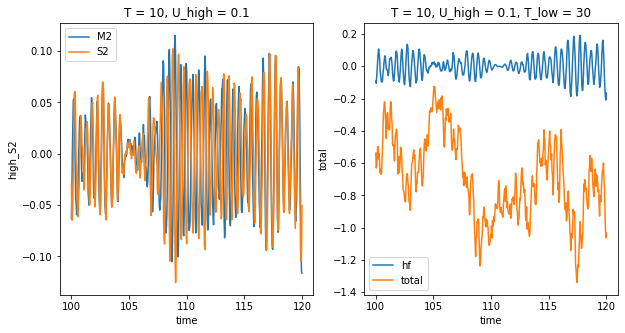

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.high_M2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='M2')
ds.high_S2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high_MS.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='total')
ax[1].legend()

#### Filter and demodulation : 
Band pass filter applied to signal : 
1) monochromatic signal, M2 frequency

2) monochromatic signal, S2 frequency 

3) superpostion of S2 and M2 ; central frequency is the mean frequency

4) total signal (M2+S2+lf) ; central frequency is the mean frequency

Notes on paramters : 

1) halfbandwidth, $d\omega$, should be defined such as : $1/d\omega\geq T_w$; where $T_w$ is the kernel length

2) $d\omega\geq \tilde T$ ; where $\tilde T$ is the hf decorrelation timescale.

In [17]:

kind = ['high_M2','high_S2','high_MS','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]


In [18]:
_ds['low'] = ds.low

In [19]:
maxlag=t_size
lags= np.arange(0,maxlag//2,1/24)
R = {}
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag = maxlag,lags=lags,**{'mode':'valid'})

In [20]:
ds_R = xr.merge([R[k] for k in kind])

In [21]:
ds_R = ds_R.compute()

In [26]:
R_low = autocorrelations(_ds,['low'],maxlag=maxlag,lags=lags,**{'mode':'valid'})
dsR_low = R_low.compute()

In [27]:
ds_R = xr.merge([ds_R,dsR_low])

In [28]:
#ds_R.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_1.nc')
ds_R.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_1_U.nc')

#### Monochromatic signal ,M2

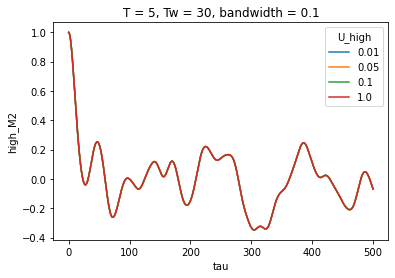

<Figure size 432x288 with 0 Axes>

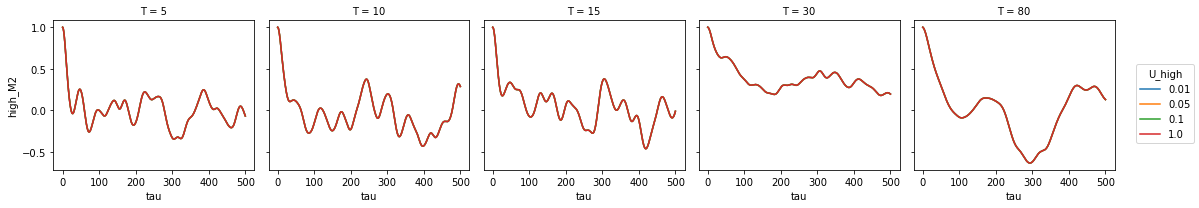

<Figure size 432x288 with 0 Axes>

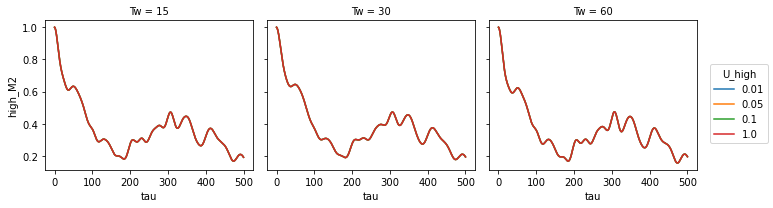

<Figure size 432x288 with 0 Axes>

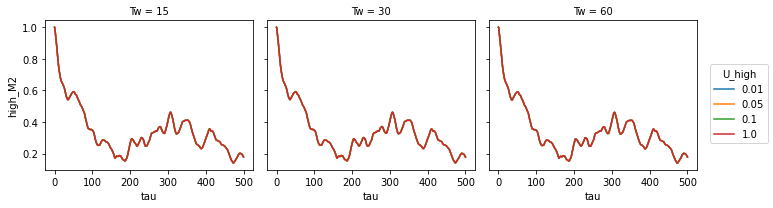

<Figure size 432x288 with 0 Axes>

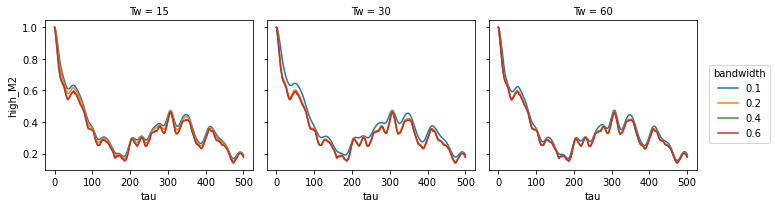

In [30]:
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30).plot(hue='U_high')
plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.6,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(T=30,U_high=0.1).plot(hue='bandwidth',col='Tw')

Notes : 

For large enough bandwidth compared to the decorrelation timescale, kernel length and bandwidth do not have impact on the results.

The form of autocovariance changes depending on the amplitude (mean over several samples should correct this).

NB : Short decorrealtion timescale compared to the band width ($\tilde T\leq T_\omega$) introduces oscillations in the autocovariance (expected)

#### High frequency signal (M2+S2)

<Figure size 432x288 with 0 Axes>

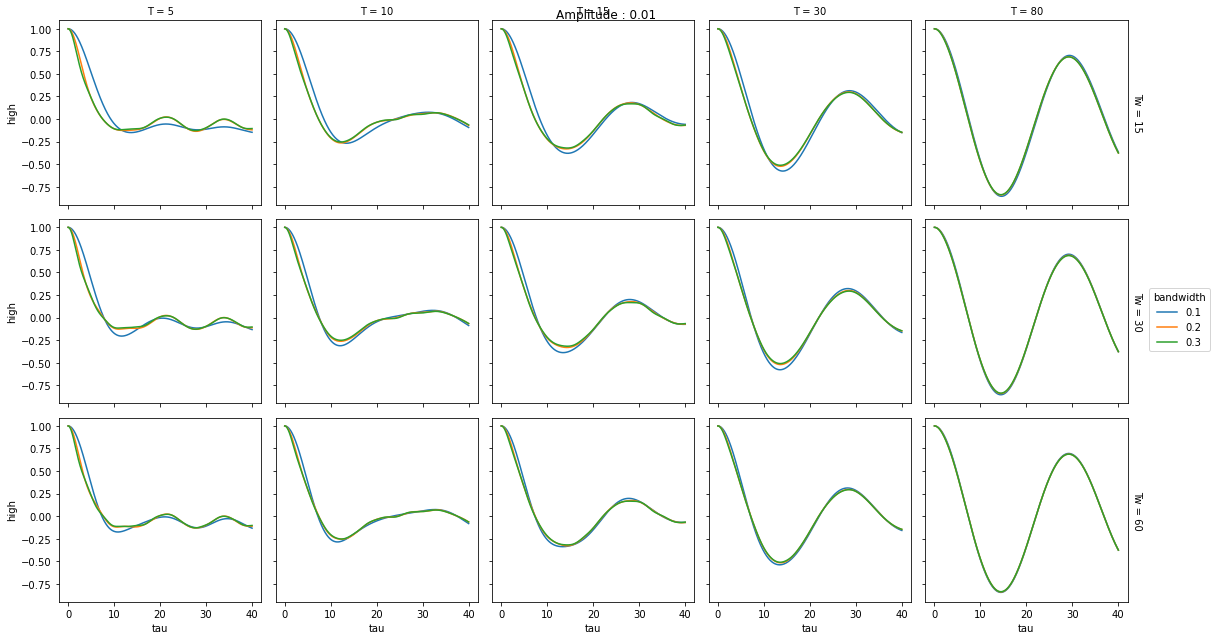

<Figure size 432x288 with 0 Axes>

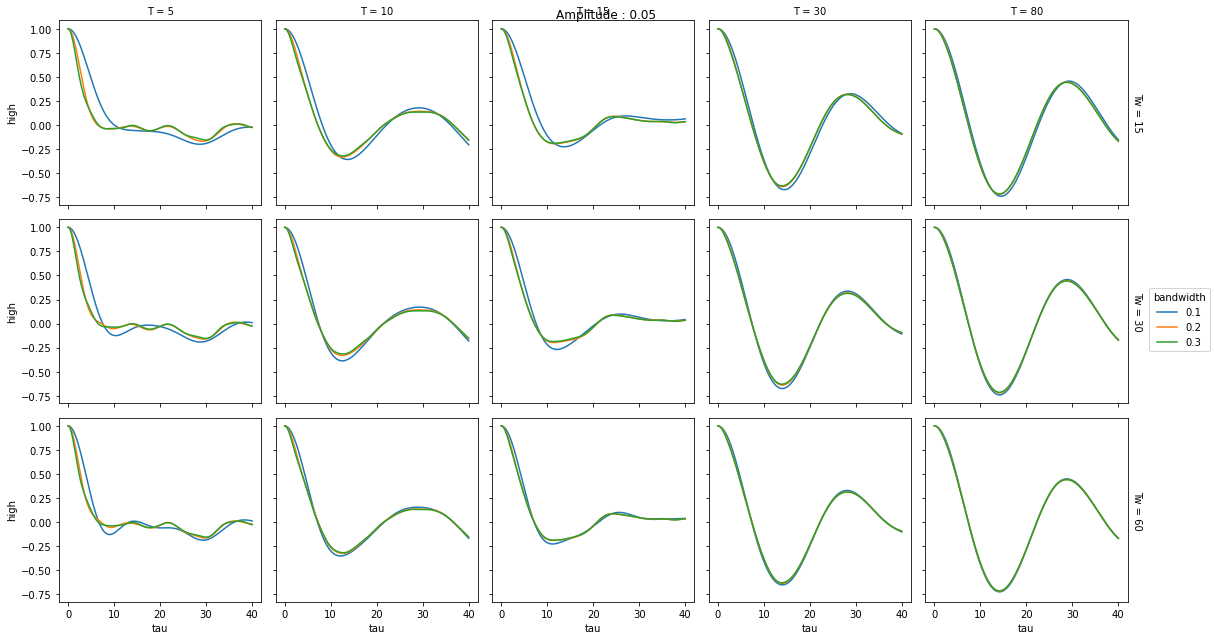

<Figure size 432x288 with 0 Axes>

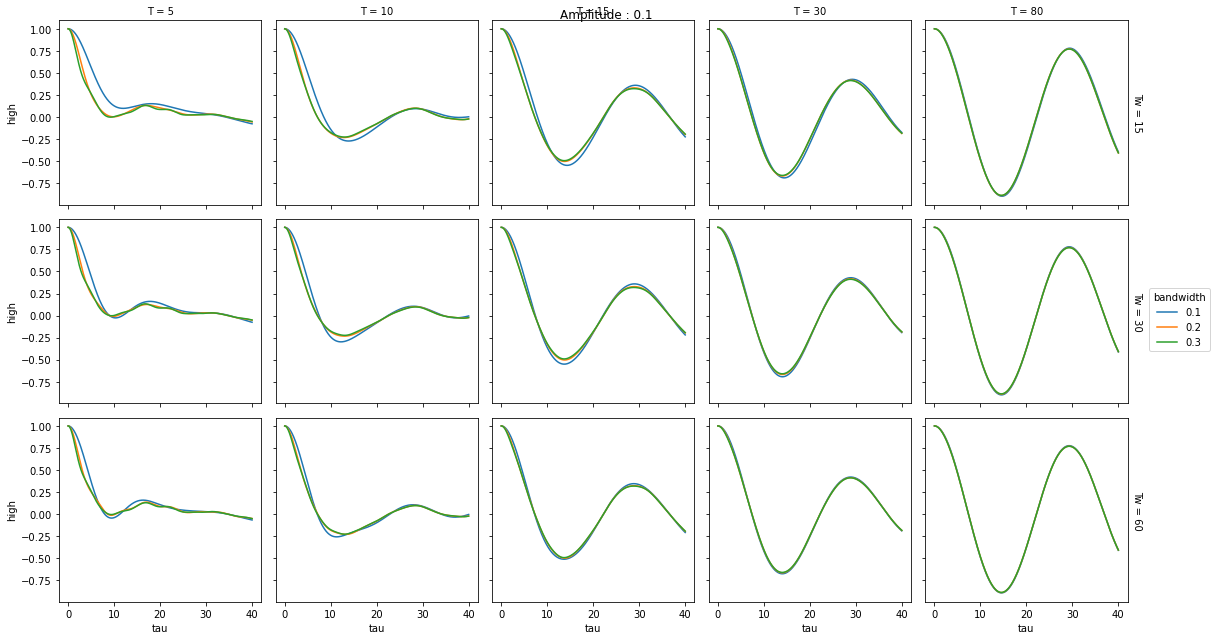

<Figure size 432x288 with 0 Axes>

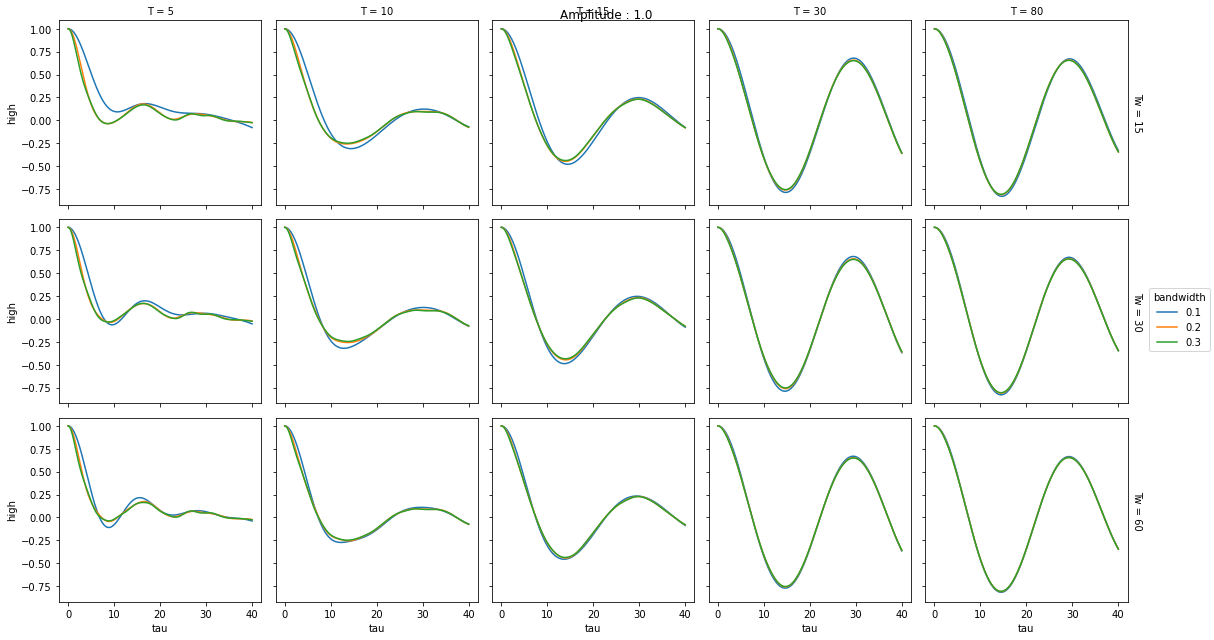

In [20]:
for U in ds_R.U_high:
    fig = plt.figure()
    (ds_R.high/ds_R.high.isel(tau=0)).sel(U_high=U).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()
    

Notes : 

Larger kernel size decreases the dependence to the bandwidth at fixed decorrelation timescale.

For decorrelation timescale of 5 days, the spring neap cycle is not captured anymore (osclliations at shorter period appears).

Form for decorrelation timescales changes depending on the amplitude (stronger for T=5days).

NB : Here one possible explaination for oscillations of period shorter than spring neap cycle is decorrelation timescale too small compared to the cycle, no significant impact of bandwidth, etc in the observed cases (we did not test very small kernel size that could introduce new problems).

Comparison to monochromatic signal : 

The oscillations observed for $\tilde T\leq T_\omega$ observed in the monochromatic case are not observed anymore. The fact that the decorrelation timescale is shorter than the spring neap cycle seems to have a dominiant effect and creates oscillations even in cases of large enough bandwidth ($\tilde T \geq T_\omega$)

### Several draw

In [9]:
nb_draws = 30
seed = 0
#T,T_low = [5,10,15,30,80],[5,15,30]
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
M2 = tseries("high_M2",draws=nb_draws).rename('M2')#,chunks={'draw':2}
S2 = tseries("high_S2",draws=nb_draws).rename('S2')# ,chunks={'draw':2}
#N2 = tseries("high_N2",draws=nb_draws).rename('N2')#,chunks={'draw':2}
#K2 = tseries("high_K2",draws=nb_draws).rename('K2')# ,chunks={'draw':2}
low = tseries("low",draws=nb_draws).rename({'T':'T_low'})#,chunks={'draw':4}

#da_high_M2 = da_high_M2.rename('high_M2')
#da_high_S2 = xr.concat([tseries("high_S2") for i in range(nb)],dim='sample'
#                      ).assign_coords({'sample':np.arange(0,nb)})
#da_high_S2 = da_high_S2.rename('high_S2')
#da_low = xr.concat([tseries("low") for i in range(nb)],dim='sample').assign_coords({'sample':np.arange(0,nb)})

In [54]:
nb_draws = 79
M2 = tseries("high_M2",draws=nb_draws,chunks={'draw':2}).compute()

In [83]:
#S2 = tseries("high_S2",draws=nb_draws,chunks={'draw':2}).rename('S2').compute()
low = tseries("low",draws=nb_draws-1,chunks={'draw':4}).rename({'T':'T_low'}).compute()

In [103]:
M2 = M2.chunk({'T':-1,'U_high':-1,'time':-1,'draw':-1})
S2 = S2.chunk({'T':-1,'U_high':-1,'time':-1,'draw':-1})
low = low.chunk({'T_low':-1,'time':-1,'draw':-1})

In [10]:
low = low.sel(draw=M2.draw)
#M2 = M2.sel(draw=low.draw)
#S2 = S2.sel(draw=low.draw)

In [11]:
M2 = xr.concat([M2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
S2 = xr.concat([S2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
ds = xr.merge([M2,S2, low])
ds

<xarray.Dataset>
Dimensions:  (T: 5, time: 1920, draw: 30, U_high: 4, T_low: 3)
Coordinates:
  * T        (T) int64 5 10 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 79.88 79.92 79.96
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100
Data variables:
    M2       (U_high, T, time, draw) float64 dask.array<chunksize=(1, 5, 1920, 30), meta=np.ndarray>
    S2       (U_high, T, time, draw) float64 dask.array<chunksize=(1, 5, 1920, 30), meta=np.ndarray>
    low      (T_low, time, draw) float64 dask.array<chunksize=(3, 1920, 30), meta=np.ndarray>

In [12]:
ds = xr.broadcast(ds)[0].persist()

In [13]:
ds['high_MS'] = ds.M2+ds.S2
#ds_stat['high_MSNK'] = ds_stat.M2+ds_stat.S2+ds_stat.N2+ds_stat.K2
ds['total'] = ds.M2+ds.S2+ds.low
#ds_stat['total_NK'] = ds_stat.M2+ds_stat.S2+ds_stat.N2+ds_stat.K2+ds_stat.low

In [14]:
ds = ds.persist()

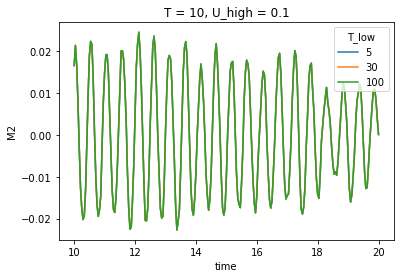

In [16]:
ds.M2.isel(T=1).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(label='M2',hue='T_low')



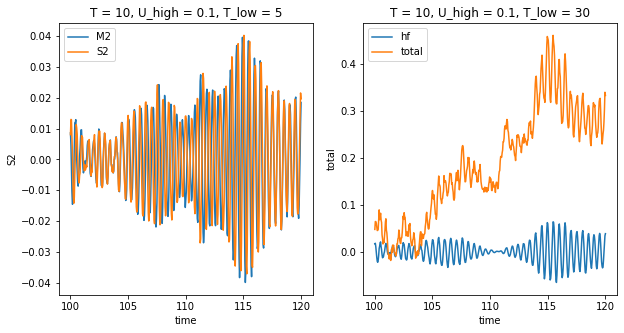

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.M2.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(100,120)).mean('draw').plot(ax=ax[0],label='M2')
ds.S2.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(100,120)).mean('draw').plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high_MS.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(100,120)).mean('draw').plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1,U_high=2).sel(time=slice(100,120)).mean('draw').plot(ax=ax[1],label='total')
ax[1].legend()

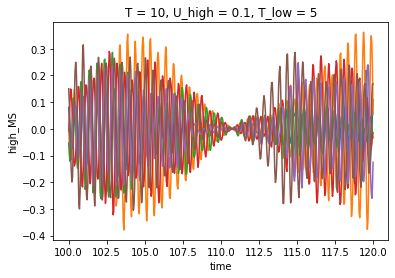

In [17]:
ds.high_MS.isel(T=1,U_high=2,T_low=0).sel(time=slice(100,120),draw=slice(0,5)).plot(hue='draw',add_legend=False)

#ds_stat.high.isel(T=1,U_high=2).sel(time=slice(100,120)).isel(draw=4).plot()

In [17]:
#Tw = [15,30,60]
#band = [0.1,0.2,0.3]
kind  = ['M2','S2','high_MS','total']
_ds_stat = {}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds_stat[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})#.compute()

In [18]:
R_stat = {}
maxlag = t_size
lags = np.arange(0,maxlag//2,1/24)
for k in kind:
    R_stat[k] = autocorrelations(_ds_stat[k],[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})

/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,


In [23]:
_ds_stat['low'] = ds_stat.low


In [ ]:
R_low = autocorrelations(ds_stat,['low'])

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-efdaee5265e5b0aacea3045e5ea10d76', 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-efdaee5265e5b0aacea3045e5ea10d76', 0)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-efdaee5265e5b0aacea3045e5ea10d76', 0)": []} state: [None] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-efdaee5265e5b0aacea3045e5ea10d76', 0)
NoneType: None


In [19]:
ds_R_stat = xr.merge([R_stat[k] for k in kind]) #,'total'

In [ ]:
xr.merge([ds_R_stat,R_low])

In [20]:
ds_R_mean = ds_R_stat.mean('draw')

In [21]:
ds_R_mean = ds_R_mean.persist()

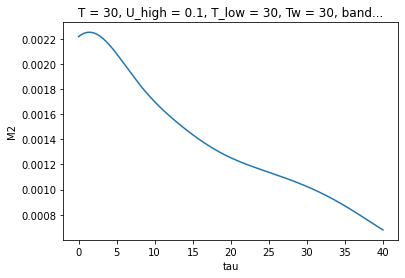

In [22]:
ds_R_mean.sel(T=30,Tw=30,U_high=0.1,bandwidth=0.2,T_low=30).M2.sel(tau=slice(0,40)).plot()

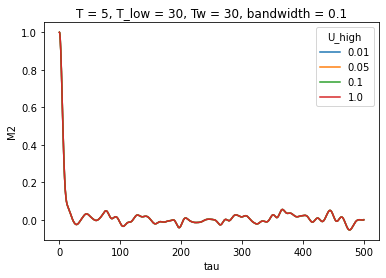

<Figure size 432x288 with 0 Axes>

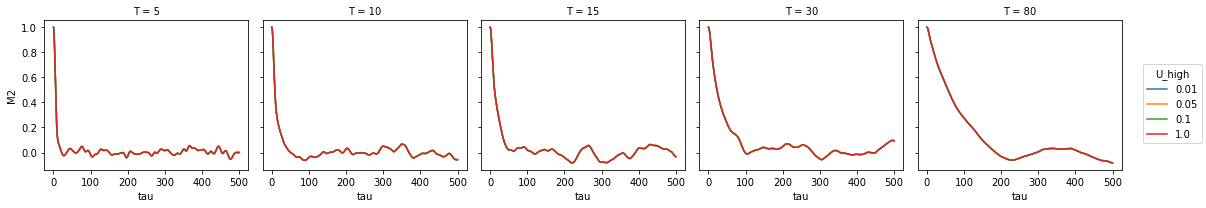

<Figure size 432x288 with 0 Axes>

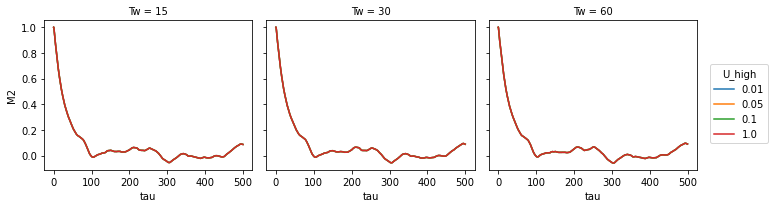

<Figure size 432x288 with 0 Axes>

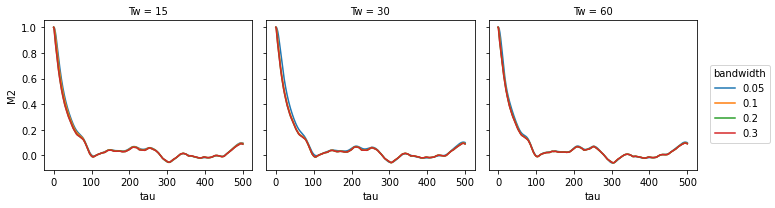

In [28]:
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30,T_low=30).plot(hue='U_high')
plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30,T_low=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.3,T=30,T_low=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(T=30,U_high=0.1,T_low=30).plot(hue='bandwidth',col='Tw')

In [23]:
ds_R_mean = ds_R_mean.compute()

In [24]:
ds_R_mean.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_30_U_valid_80.nc')

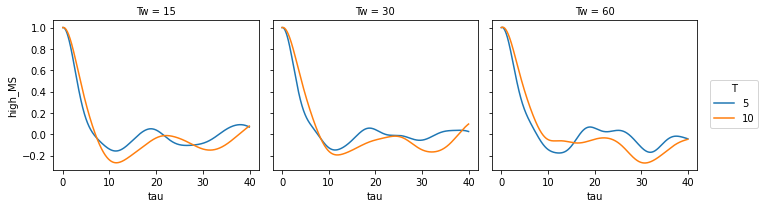

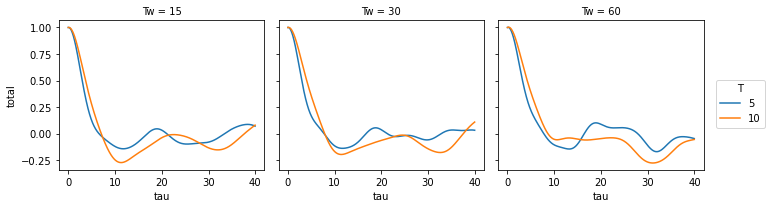

In [35]:
(ds_R_mean['high_MS']/ds_R_mean['high_MS'].isel(tau=0)).sel(U_high=0.1,T_low=30,bandwidth=0.4).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

(ds_R_mean['total']/ds_R_mean['total'].isel(tau=0)).sel(U_high=0.1,T_low=30,bandwidth=0.4).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

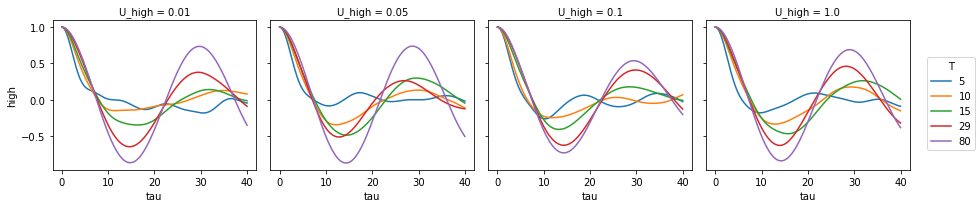

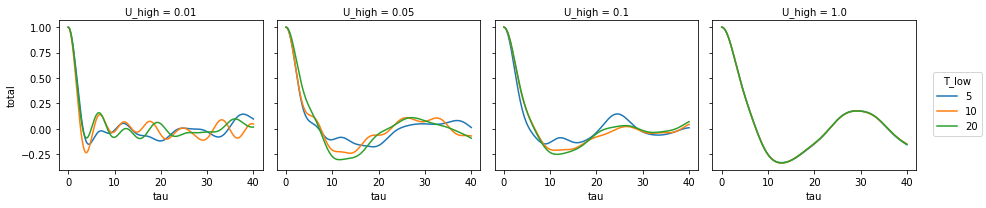

In [96]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(Tw=30).sel(tau=slice(0,40)).plot(hue='T',col='U_high')
(ds_R['total']/ds_R['total'].isel(tau=0)).sel(T=10,Tw=30).sel(tau=slice(0,40)).plot(hue='T_low',col='U_high')

In [36]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
